# Curve fitting in python
## A.M.C. Dawes - 2015
An introduction to various curve fitting routines useful for physics work.

The first cell is used to import additional features so they are available in our notebook. `matplotlib` provides plotting functions and `numpy` provides math and array functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Next we define `x` as a linear space with 100 points that range from 0 to 10.

In [2]:
x = np.linspace(0,10,100)

`y` is mock data that we create by linear function with a slope of 1.45. We also add a small amount of random data to simulate noise as if this were a measured quantity.

In [3]:
y = 1.45 * x + 1.3*np.random.random(len(x))

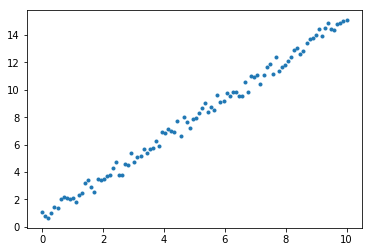

In [4]:
plt.plot(x,y,".")

The data is pretty clearly linear, but we can fit a line to determine the slope. A 1st order polynomial is a line, so we use `polyfit`:

In [5]:
# execute the fit on the data; a 1-dim fit (line)
fit = np.polyfit(x, y, 1,full=True)  

The fit is stored in a variable called `fit` which has several elements. We can print them out with nice labels using the following cell:

In [7]:
print("coeffients:", fit[0])
print("residuals:", fit[1])
print("rank:", fit[2])
print("singular_values:", fit[3])
print("rcond:", fit[4])

coeffients: [1.44804056 0.69812766]
residuals: [11.89618385]
rank: 2
singular_values: [1.36522772 0.36898954]
rcond: 2.220446049250313e-14


The main thing we want is the list of coefficients. These are the values in the polynomial that was a best fit. We can create a function (called `f`) that is the best fit polynomial. Then it is easy to plot both together and see that the fit is reasonable.

In [8]:
f = np.poly1d(fit[0])  # create a function using the fit parameters

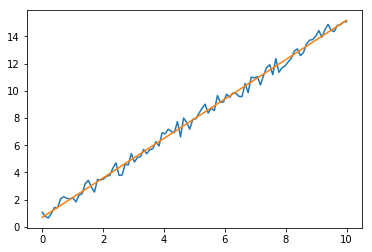

In [9]:
plt.plot(x,y)
plt.plot(x,f(x))

## General function fitting
### For more than just polynomials
> "When choosing a fit, Polynomial is almost always the wrong answer"

Often there is a better model that describes the data. In most cases this is a known function; something like a power law or an exponential. In these cases, there are two options:
1. Convert the variables so that a plot will be linear (i.e. plot the `log` of your data, or the square root, or the square etc.). This is highly effective becuase a linear fit is always (yes always) more accurate than a fit of another function.
2. Perform a nonlinear fit to the function that models your data. We'll illustrate this below and show how even a "decent" fit gives several % error.

First, we import the functions that do nonlinear fitting:

In [9]:
from scipy.optimize import curve_fit

Then define a function that we expect models our system. In this case, exponential decay with an offset.

In [10]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

Create a pure (i.e. exact) set of data with some parameters, and then simulate some data of the same system (by adding random noise).

In [11]:
y = func(x, 2.5, 0.6, 0.5)
ydata = y + 0.2 * np.random.normal(size=len(x))

Now carry out the fit. `curve_fit` returns two outputs, the fit parameters, and the covariance matrix. We won't use the covariance matrix yet, but it's good practice to save it into a variable.

In [12]:
parameters, covariance = curve_fit(func, x, ydata)
parameters  #the fit results for a, b, c

array([ 2.40082231,  0.54439262,  0.48824428])

We can see the parameters are a reasonable match to the pure function we created above. Next, we want to create a "best fit" data set but using the parameters in the model function `func`. The "splat" operator is handy for this, it unpacks the `parameters` array into function arguments `a`, `b`, and `c`.

In [13]:
yfit = func(x, *parameters) 
# the splat operator unpacks an array into function arguments

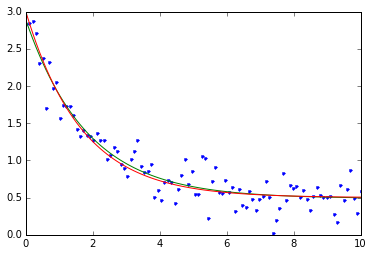

In [14]:
plt.plot(x,ydata,".")
plt.plot(x,yfit)
plt.plot(x,y)

Looks pretty good as far as fits go. Let's check out the error:

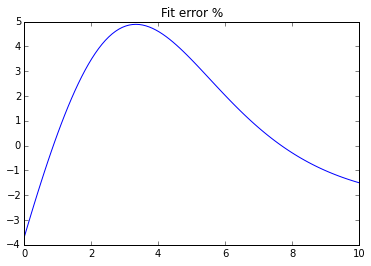

In [15]:
plt.plot(x,((yfit-y)/y)*100)
plt.title("Fit error %")

To further illustrate the variation in this fit, repeat all the cells (to get new random noise in the data) and you'll see the fit changes. Sometimes, the error is as large as 10%. Compare this to a linear fit of log data and I bet you see much less variation in the fit!

## Modeling by rescaling data
### The "fit a line to anything" approach
> "With a small enough data set, you can always fit it to a line"

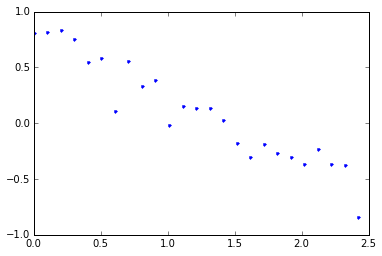

In [16]:
ylog = np.log(ydata[:25] - ydata[-1])
plt.plot(x[:25],ylog,".")

In [17]:
fitlog = np.polyfit(x[:25], ylog[:25], 1,full=True)  

In [18]:
fitlog

(array([-0.5888762 ,  0.82399638]),
 array([ 0.44348398]),
 2,
 array([ 1.36277029,  0.37796447]),
 5.5511151231257827e-15)

In [19]:
ylog.shape

(25,)

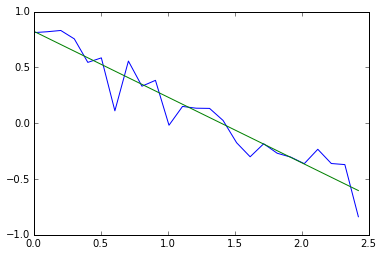

In [20]:
flog = np.poly1d(fitlog[0])
plt.plot(x[:25],ylog)
plt.plot(x[:25],flog(x[:25]))

Now to finally back out the exponential from the linear fit:

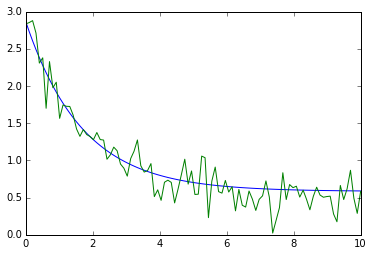

In [21]:
ylogfit = np.exp(flog(x))
plt.plot(x,ylogfit+ydata[-1])
plt.plot(x,ydata)

Clearly the tail is a bit off, the next iteration is to average the tail end and use that as the y shift instead of using just the last point.

In [22]:
yshift = np.average(ydata[-20:])
yshift

0.51212140091282721

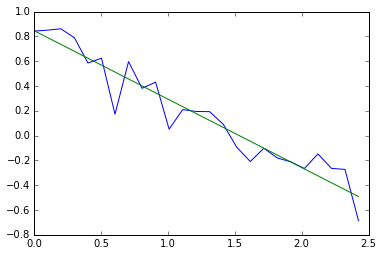

In [23]:
ylog = np.log(ydata[:25] - yshift)
fitlog = np.polyfit(x[:25], ylog[:25], 1,full=True)  
flog = np.poly1d(fitlog[0])
plt.plot(x[:25],ylog)
plt.plot(x[:25],flog(x[:25]))

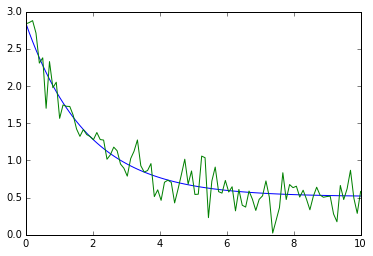

In [24]:
ylogfit = np.exp(flog(x))
plt.plot(x,ylogfit+yshift)
plt.plot(x,ydata)

Very nice.